Привет,
задачка:
1. подключиться к https://openweathermap.org/
manual - https://openweathermap.org/api
2. забрать погодные данные для г. Санкт-Петербург в период с "неважно"(как хочешь) по 01.09.2020
3. записывать данные в таблицу MS SQL (или Postgre)
4. создать модель прогнозирования для параметров "temp" и "feels_like" (сделать прогнозную модель на основе других параметров)
запушить на гит результаты, после этого продолжим разговор

вот, если что .csv выгруженная с данного сайта (локация - Питер, период: 01.01.2015 - 20.08.2020)
визуализируй еще, пжлст, корреляционную матрицу

.csv на случай, если не реализуешь api,
чтобы все равно построить модель и продемонстрировать ее

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [3]:
weather_df = pd.read_csv('weather_2015-2020.csv')
weather_df.head(4)

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1420070400,2015-01-01 00:00:00 +0000 UTC,10800,Saint Petersburg,59.931058,30.36091,274.61,270.75,274.150,275.350,...,260,NaN,NaN,NaN,NaN,90,701,Mist,mist,50n
1,1420074000,2015-01-01 01:00:00 +0000 UTC,10800,Saint Petersburg,59.931058,30.36091,275.04,270.55,274.633,275.342,...,270,NaN,NaN,NaN,NaN,90,701,Mist,mist,50n
2,1420077600,2015-01-01 02:00:00 +0000 UTC,10800,Saint Petersburg,59.931058,30.36091,275.27,271.52,275.141,275.475,...,280,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
3,1420081200,2015-01-01 03:00:00 +0000 UTC,10800,Saint Petersburg,59.931058,30.36091,275.29,270.14,275.150,275.532,...,270,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n


In [4]:
weather_df.dt_iso[44580] # 2020 - 8921 ts

'2020-01-01 00:00:00 +0000 UTC'

In [5]:
weather_df.describe()

,dt,timezone,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id
count,5.022200e+04,50222.0,5.022200e+04,5.022200e+04,50222.000000,50222.000000,50222.000000,50222.000000,50222.000000,0.0,0.0,50222.000000,50222.000000,50222.000000,4736.000000,0.0,1653.000000,0.0,50222.000000,50222.000000
mean,1.509016e+09,10800.0,5.993106e+01,3.036091e+01,279.524891,275.523456,278.344669,280.447519,1011.916929,NaN,NaN,77.189220,3.848103,189.358727,0.568682,NaN,0.351119,NaN,62.095815,753.378101
std,5.132732e+07,0.0,2.825146e-11,2.787842e-11,9.105861,10.503659,9.069676,9.161108,11.599093,NaN,NaN,17.154819,2.386624,97.723524,0.664843,NaN,0.312632,NaN,32.395432,104.150033
min,1.420070e+09,10800.0,5.993106e+01,3.036091e+01,246.280000,193.280000,241.550000,247.150000,968.000000,NaN,NaN,6.000000,0.110000,0.000000,0.040000,NaN,0.040000,NaN,0.000000,200.000000
25%,1.464560e+09,10800.0,5.993106e+01,3.036091e+01,273.350000,268.250000,272.616500,274.150000,1005.000000,NaN,NaN,68.000000,2.000000,110.000000,0.250000,NaN,0.170000,NaN,40.000000,800.000000
50%,1.509010e+09,10800.0,5.993106e+01,3.036091e+01,278.470000,274.010000,277.450000,279.162000,1012.000000,NaN,NaN,82.000000,4.000000,210.000000,0.330000,NaN,0.250000,NaN,75.000000,802.000000
75%,1.553460e+09,10800.0,5.993106e+01,3.036091e+01,286.880000,284.210000,285.551000,288.032750,1019.000000,NaN,NaN,92.000000,5.000000,270.000000,0.560000,NaN,0.400000,NaN,90.000000,804.000000
max,1.597964e+09,10800.0,5.993106e+01,3.036091e+01,304.190000,304.420000,302.951000,305.930000,1053.000000,NaN,NaN,100.000000,114.000000,360.000000,10.410000,NaN,2.790000,NaN,100.000000,804.000000


Избавимся от колонок с нулевыми значениями и с постоянными значениями  

In [6]:
weather_df = weather_df.drop(['sea_level','grnd_level', 'timezone', 'lat',
                              'rain_3h','snow_3h', 'lon', 'city_name',
                              'dt_iso'],axis=1)
weather_df = weather_df.replace(np.nan,0)

Probably delite it

In [7]:
unique_weather_main = weather_df['weather_main'].unique()
unique_weather_description = weather_df['weather_description'].unique()
unique_weather_icon = weather_df['weather_icon'].unique()
unique_weather_id = weather_df['weather_id'].unique()
len(unique_weather_description), len(unique_weather_main), len(unique_weather_icon), len(unique_weather_id)

(33, 10, 18, 33)

Видно, что 'weather_description' и 'weather_id' это одинаковые фичи

In [8]:
weather_df[['weather_description','weather_id']].head(20)

,weather_description,weather_id
0,mist,701
1,mist,701
2,overcast clouds,804
3,overcast clouds,804
4,overcast clouds,804
5,overcast clouds,804
6,overcast clouds,804
7,overcast clouds,804
8,overcast clouds,804
9,overcast clouds,804


In [9]:
weather_df = weather_df.drop(['weather_description', 'dt'], axis=1)

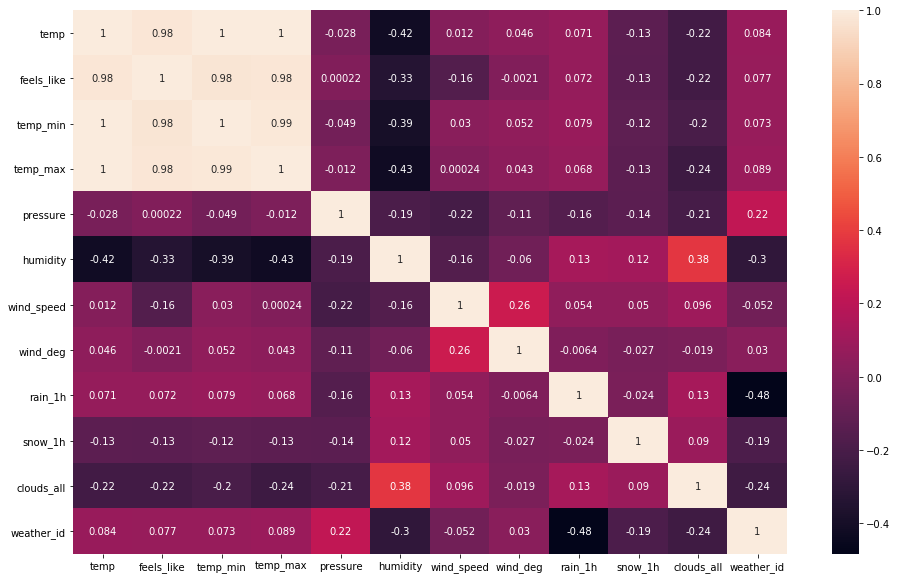

In [10]:
corr = weather_df.corr()
plt.figure(figsize = (16,10))
sns.heatmap(corr, annot = True)

### Категориальные данные 'weather_icon' и 'weather_main' меняем на числовые с помощью OneHotEncoder

In [11]:
object_cols = ['weather_main','weather_icon']
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_ft = pd.DataFrame(ohe.fit_transform(weather_df[object_cols]))
ohe_ft.index = weather_df.index
feature_names = ohe.get_feature_names()
ohe_ft.columns = feature_names
weather_df = weather_df.drop(object_cols, axis=1)
weather_df = pd.concat([weather_df, ohe_ft], axis=1)

In [12]:
import statsmodels.api as sm
col = weather_df.columns
non_staitionary_cols = []
for i in col:
    kpss_koef = sm.tsa.kpss(weather_df[i])
    if kpss_koef[1] < 0.05:
        non_staitionary_cols.append(i)
    print(f'kpss koef for {i} is {kpss_koef[1]}')

kpss koef for temp is 0.01
kpss koef for feels_like is 0.01
kpss koef for temp_min is 0.01
kpss koef for temp_max is 0.01
kpss koef for pressure is 0.01
kpss koef for humidity is 0.01
kpss koef for wind_speed is 0.01
kpss koef for wind_deg is 0.1
kpss koef for rain_1h is 0.015341682001004326
kpss koef for snow_1h is 0.1
kpss koef for clouds_all is 0.01
kpss koef for weather_id is 0.1
kpss koef for x0_Clear is 0.01
kpss koef for x0_Clouds is 0.01
kpss koef for x0_Drizzle is 0.09494367651188906
kpss koef for x0_Fog is 0.1
kpss koef for x0_Haze is 0.1
kpss koef for x0_Mist is 0.09659175494002457
kpss koef for x0_Rain is 0.017829161742735886
kpss koef for x0_Smoke is 0.1
kpss koef for x0_Snow is 0.012062709047538147
kpss koef for x0_Thunderstorm is 0.1
kpss koef for x1_01d is 0.01
kpss koef for x1_01n is 0.01
kpss koef for x1_02d is 0.01
kpss koef for x1_02n is 0.1
kpss koef for x1_03d is 0.1
kpss koef for x1_03n is 0.01
kpss koef for x1_04d is 0.01
kpss koef for x1_04n is 0.01
kpss koef f

C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWar

In [13]:
non_staitionary_cols

['temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'wind_speed',
 'rain_1h',
 'clouds_all',
 'x0_Clear',
 'x0_Clouds',
 'x0_Rain',
 'x0_Snow',
 'x1_01d',
 'x1_01n',
 'x1_02d',
 'x1_03n',
 'x1_04d',
 'x1_04n',
 'x1_09d',
 'x1_09n',
 'x1_10d',
 'x1_10n',
 'x1_13d',
 'x1_13n']

Избавимся от сезонности с помощью смещения 

In [14]:
weather_df_diff = weather_df[non_staitionary_cols] - weather_df[non_staitionary_cols].shift(24)
weather_df_diff = weather_df_diff[24:]

### По коэф. kpss видно, что все признаки стали стационарными

In [15]:
col = weather_df_diff.columns
for i in col:
    kpss_koef = sm.tsa.kpss(weather_df_diff[i])
    print(f'kpss koef for {i} is {kpss_koef[1]}')

kpss koef for temp is 0.1
kpss koef for feels_like is 0.1
kpss koef for temp_min is 0.1
kpss koef for temp_max is 0.1
kpss koef for pressure is 0.1
kpss koef for humidity is 0.1
kpss koef for wind_speed is 0.1
kpss koef for rain_1h is 0.1
kpss koef for clouds_all is 0.1
kpss koef for x0_Clear is 0.1
kpss koef for x0_Clouds is 0.1
kpss koef for x0_Rain is 0.1
kpss koef for x0_Snow is 0.1
kpss koef for x1_01d is 0.1
kpss koef for x1_01n is 0.1
kpss koef for x1_02d is 0.1
kpss koef for x1_03n is 0.1
kpss koef for x1_04d is 0.1
kpss koef for x1_04n is 0.1
kpss koef for x1_09d is 0.1
kpss koef for x1_09n is 0.1
kpss koef for x1_10d is 0.1
kpss koef for x1_10n is 0.1
kpss koef for x1_13d is 0.1
kpss koef for x1_13n is 0.1


C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\HAL9000\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWar

In [16]:
weather_df_fin = weather_df[24:]
weather_df_fin = weather_df_fin.drop(non_staitionary_cols, axis=1)
weather_df_fin = pd.concat([weather_df_diff, weather_df_fin], axis=1)
weather_df_fin

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,x0_Clear,...,x0_Haze,x0_Mist,x0_Smoke,x0_Thunderstorm,x1_02n,x1_03d,x1_11d,x1_11n,x1_50d,x1_50n
24,0.67,-0.62,0.584,0.482,-9.0,0.0,2.0,0.19,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.19,0.22,0.035,0.397,-9.0,0.0,0.0,0.50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.12,-0.56,-0.291,0.436,-9.0,0.0,1.0,0.50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.11,2.23,-0.300,0.340,-10.0,0.0,-3.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.46,1.77,-0.300,0.617,-10.0,-7.0,-2.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50217,3.05,4.03,2.750,3.340,3.0,-9.0,-1.0,0.00,0.0,-1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50218,2.73,2.91,2.056,2.780,2.0,-10.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50219,2.09,2.84,2.616,1.670,2.0,-10.0,-1.0,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50220,3.03,3.02,2.780,3.584,3.0,-17.0,0.0,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


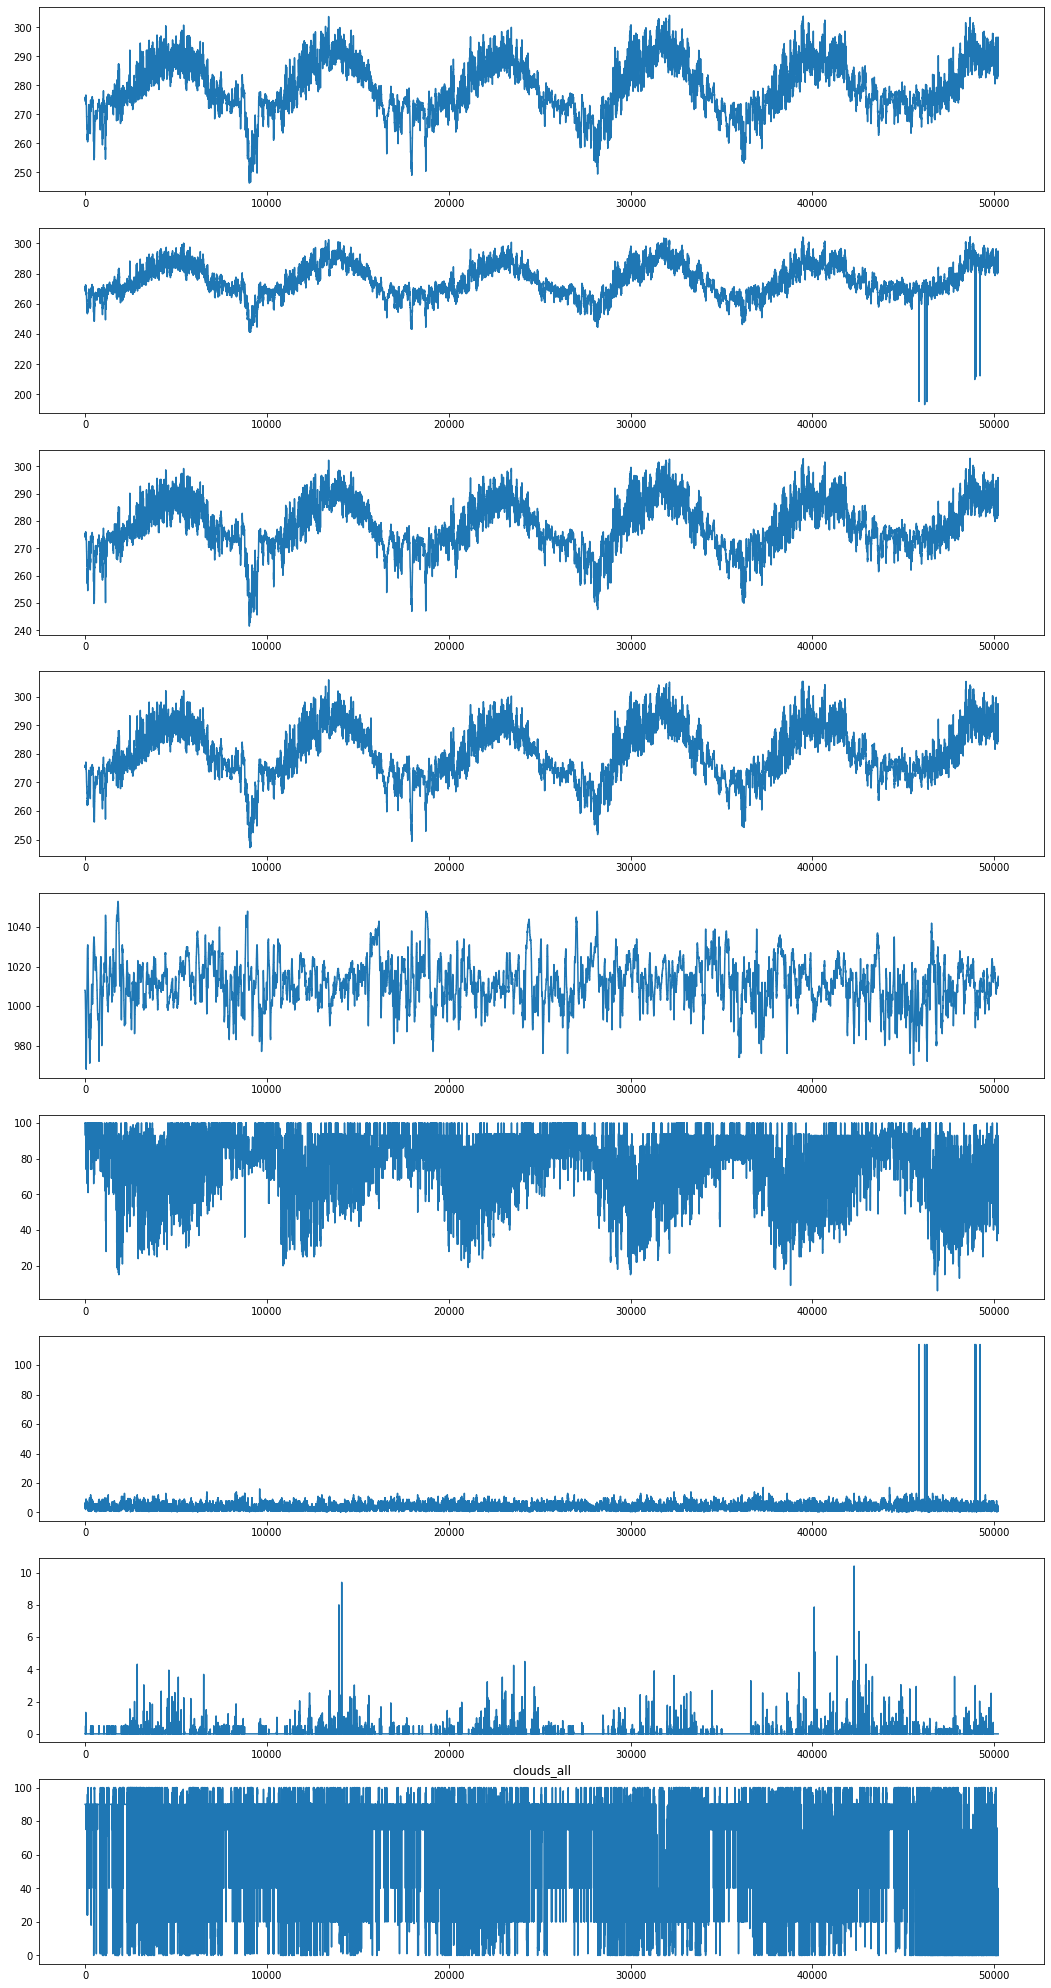

In [17]:
fig, ax_i = plt.subplots(9,figsize=(18, 36))
for i in range(len(col[:9])):
    ax_i[i].plot(weather_df[col[i]])
    plt.title(col[i])
plt.show()

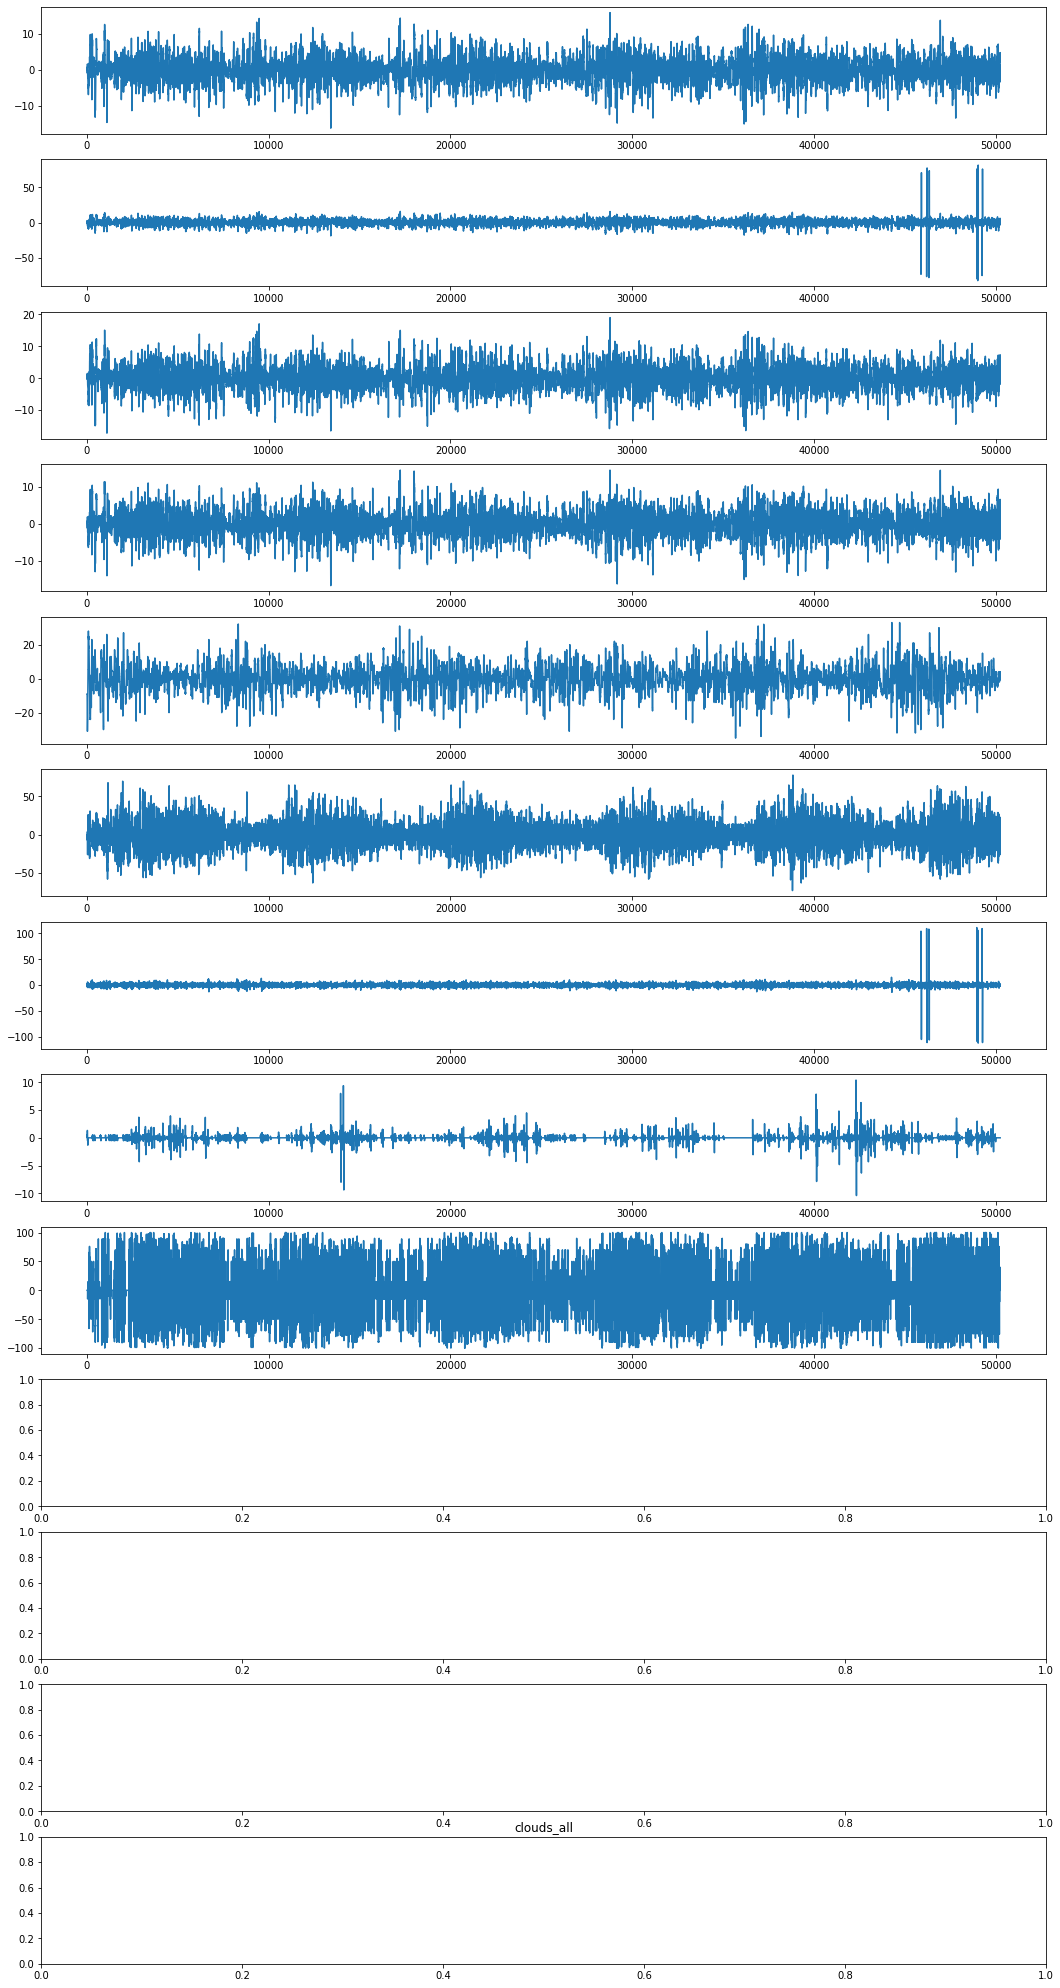

In [18]:
fig, ax_i = plt.subplots(13,figsize=(18, 36))
for i in range(len(col[:9])):
    ax_i[i].plot(weather_df_fin[col[i]])
    plt.title(col[i])
plt.show()

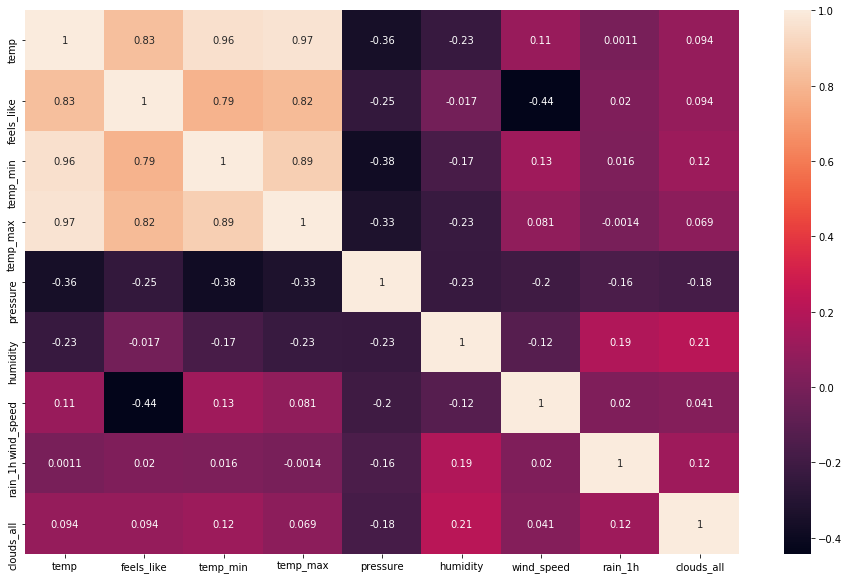

In [19]:
corr = weather_df_fin[col[:9]].corr()
plt.figure(figsize = (16,10))
sns.heatmap(corr, annot = True)

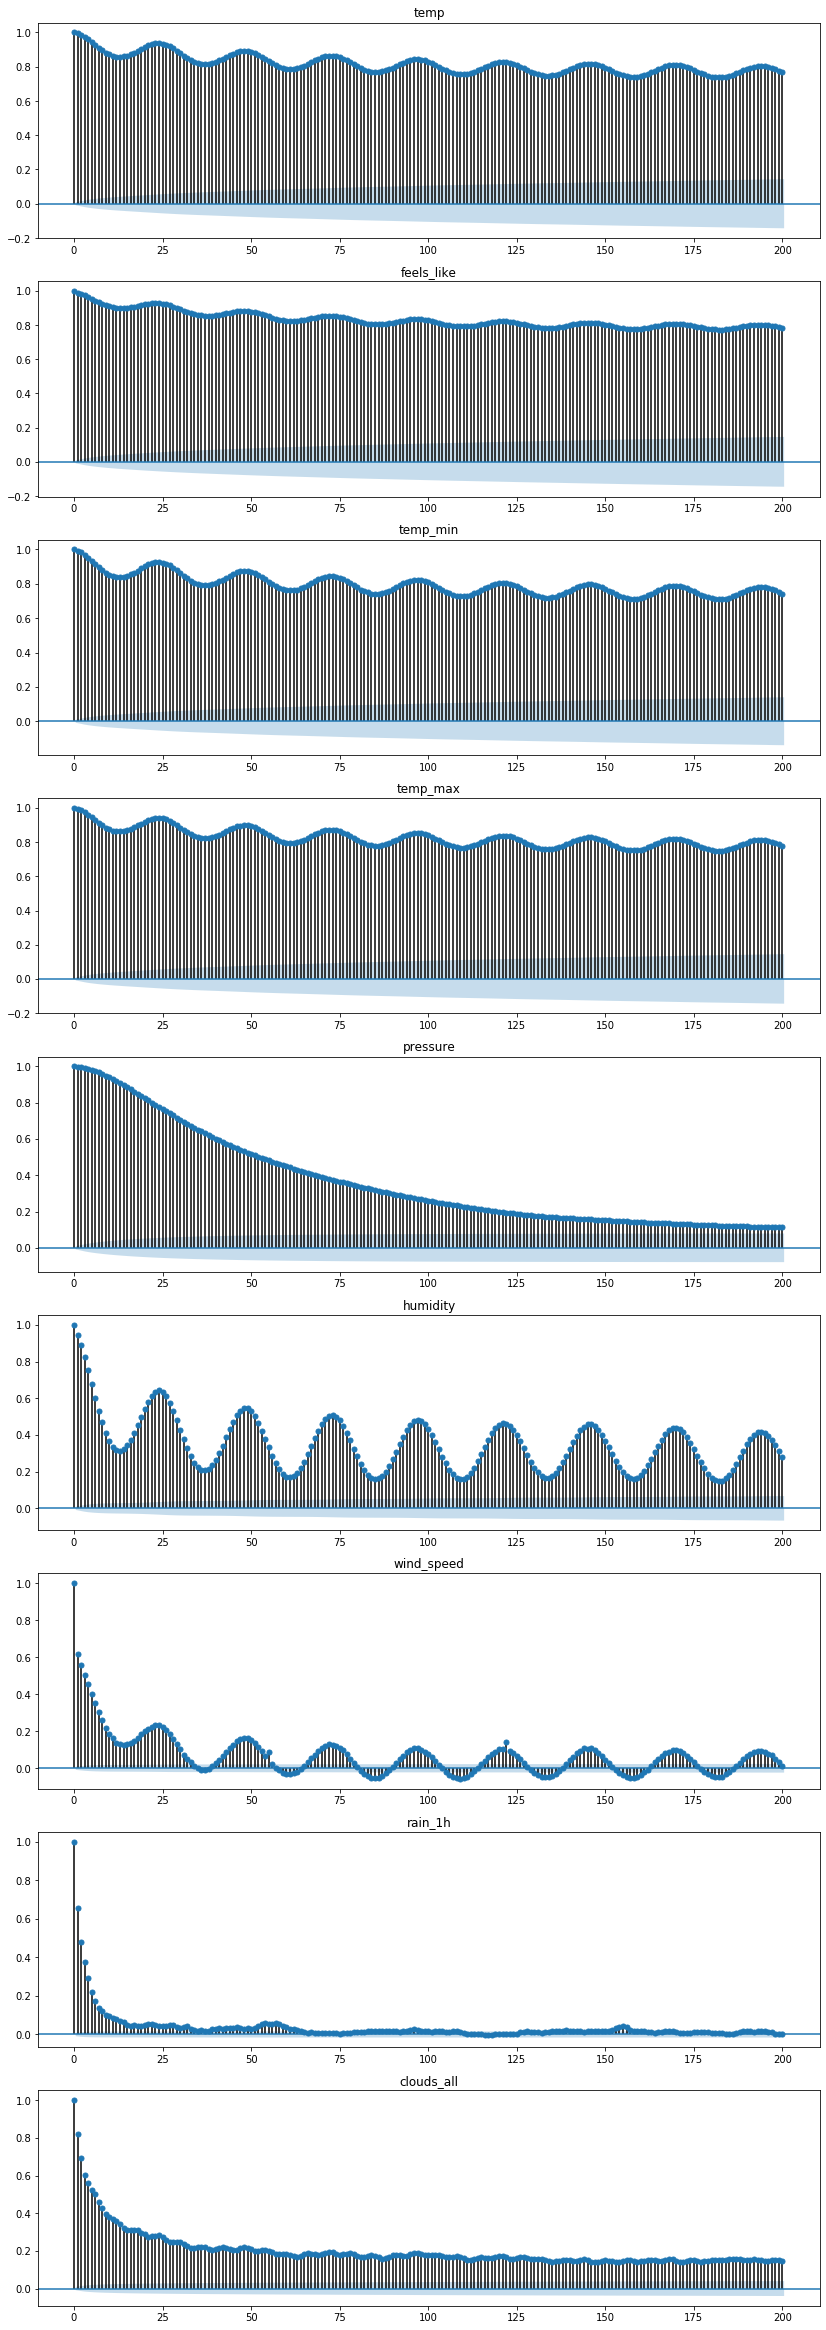

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax_i = plt.subplots(nrows=len(col[:9]), figsize=(14, 42))
for i in range(len(col[:9])):
    plot_acf(weather_df[col[i]], ax = ax_i[i],
             lags=200, title = col[i])
plt.show()

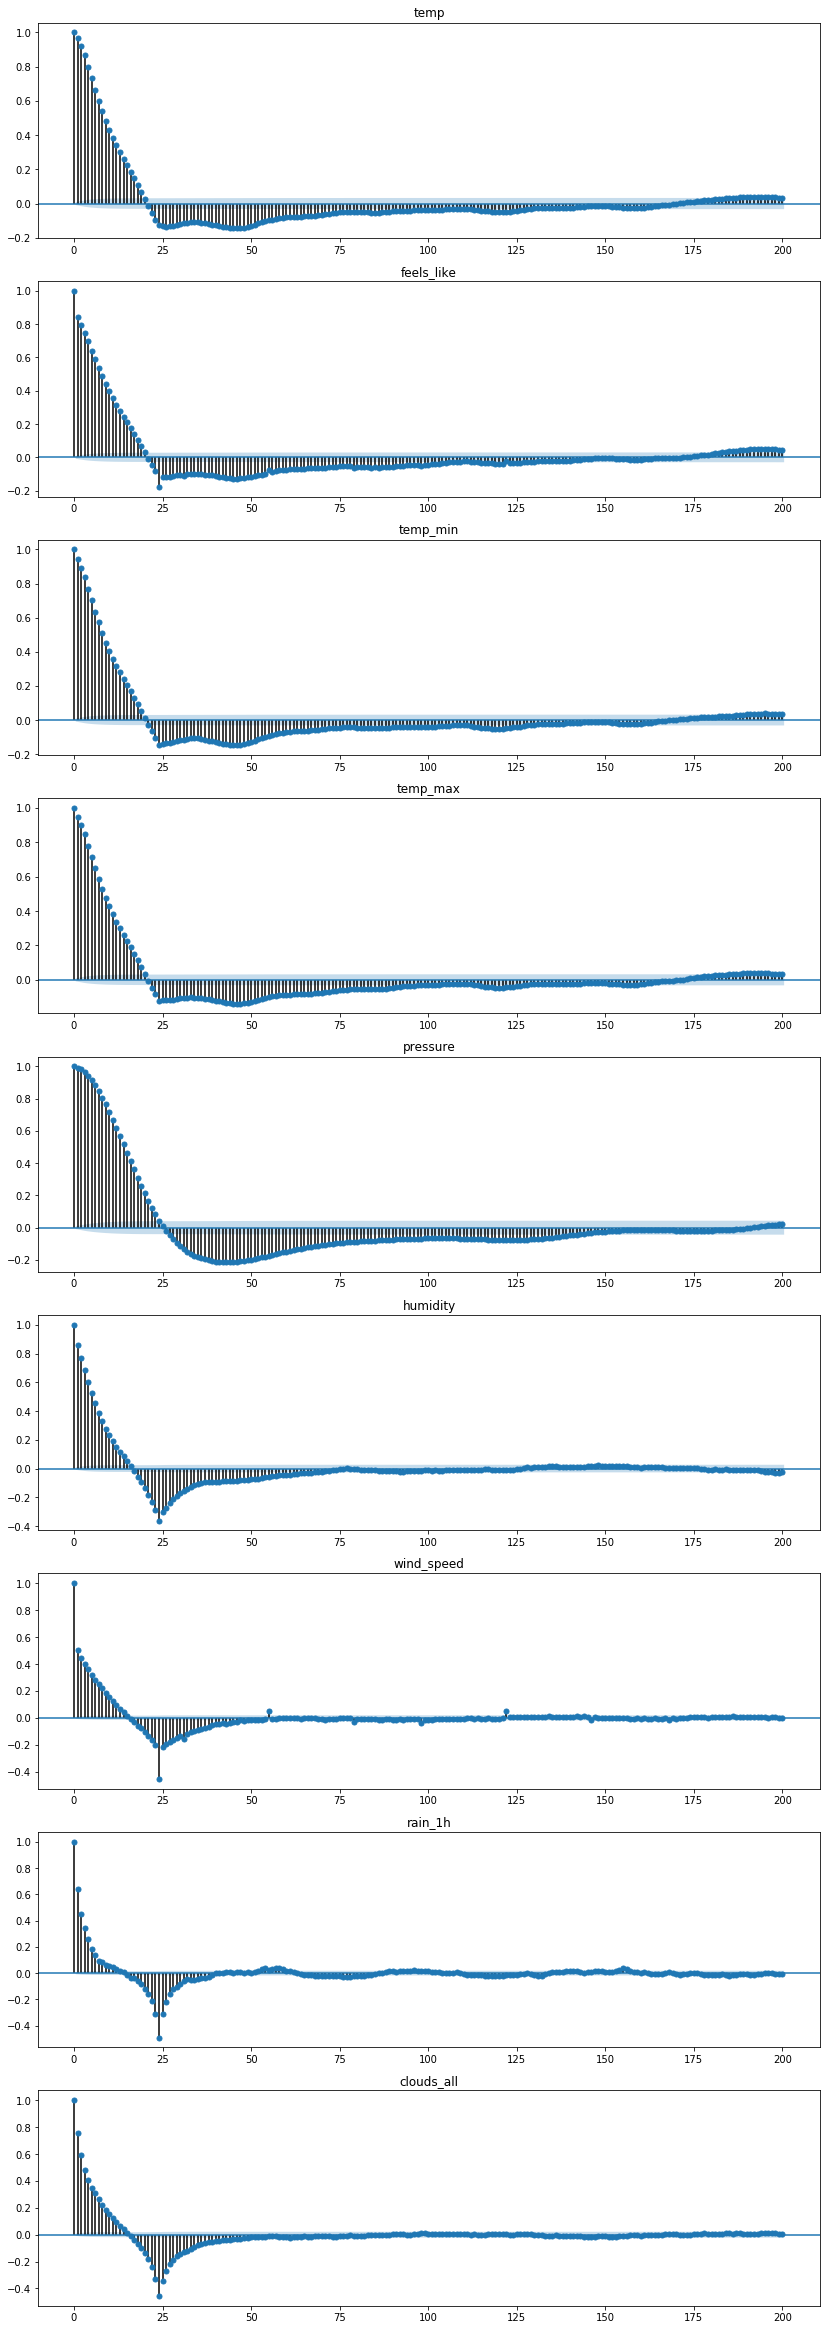

In [21]:
fig, ax_i = plt.subplots(nrows=len(col[:9]), figsize=(14, 42))
for i in range(len(col[:9])):
    plot_acf(weather_df_fin[col[i]], ax = ax_i[i],
             lags=200, title = col[i])
plt.show()

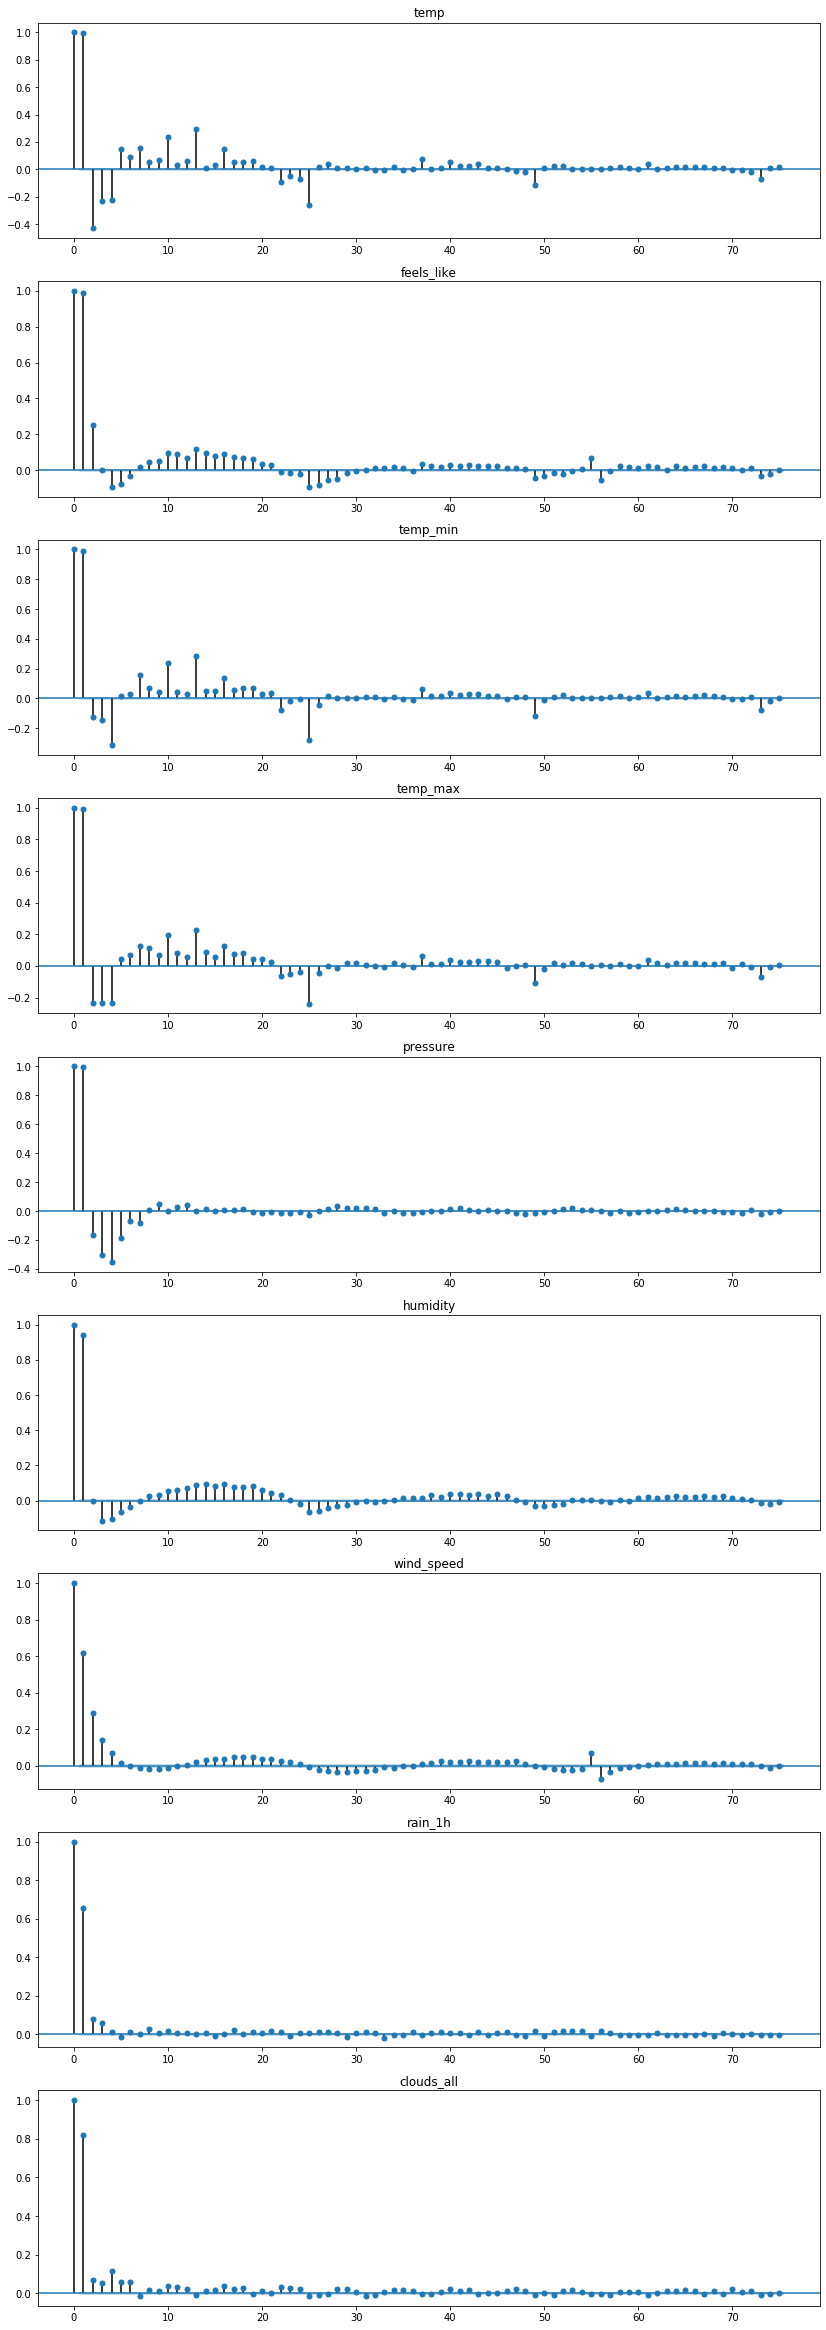

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax_i = plt.subplots(nrows=len(col[:9]), figsize=(14, 42))
for i in range(len(col[:9])):
    plot_pacf(weather_df[col[i]], ax = ax_i[i],
              lags=75, title = col[i])
plt.show()

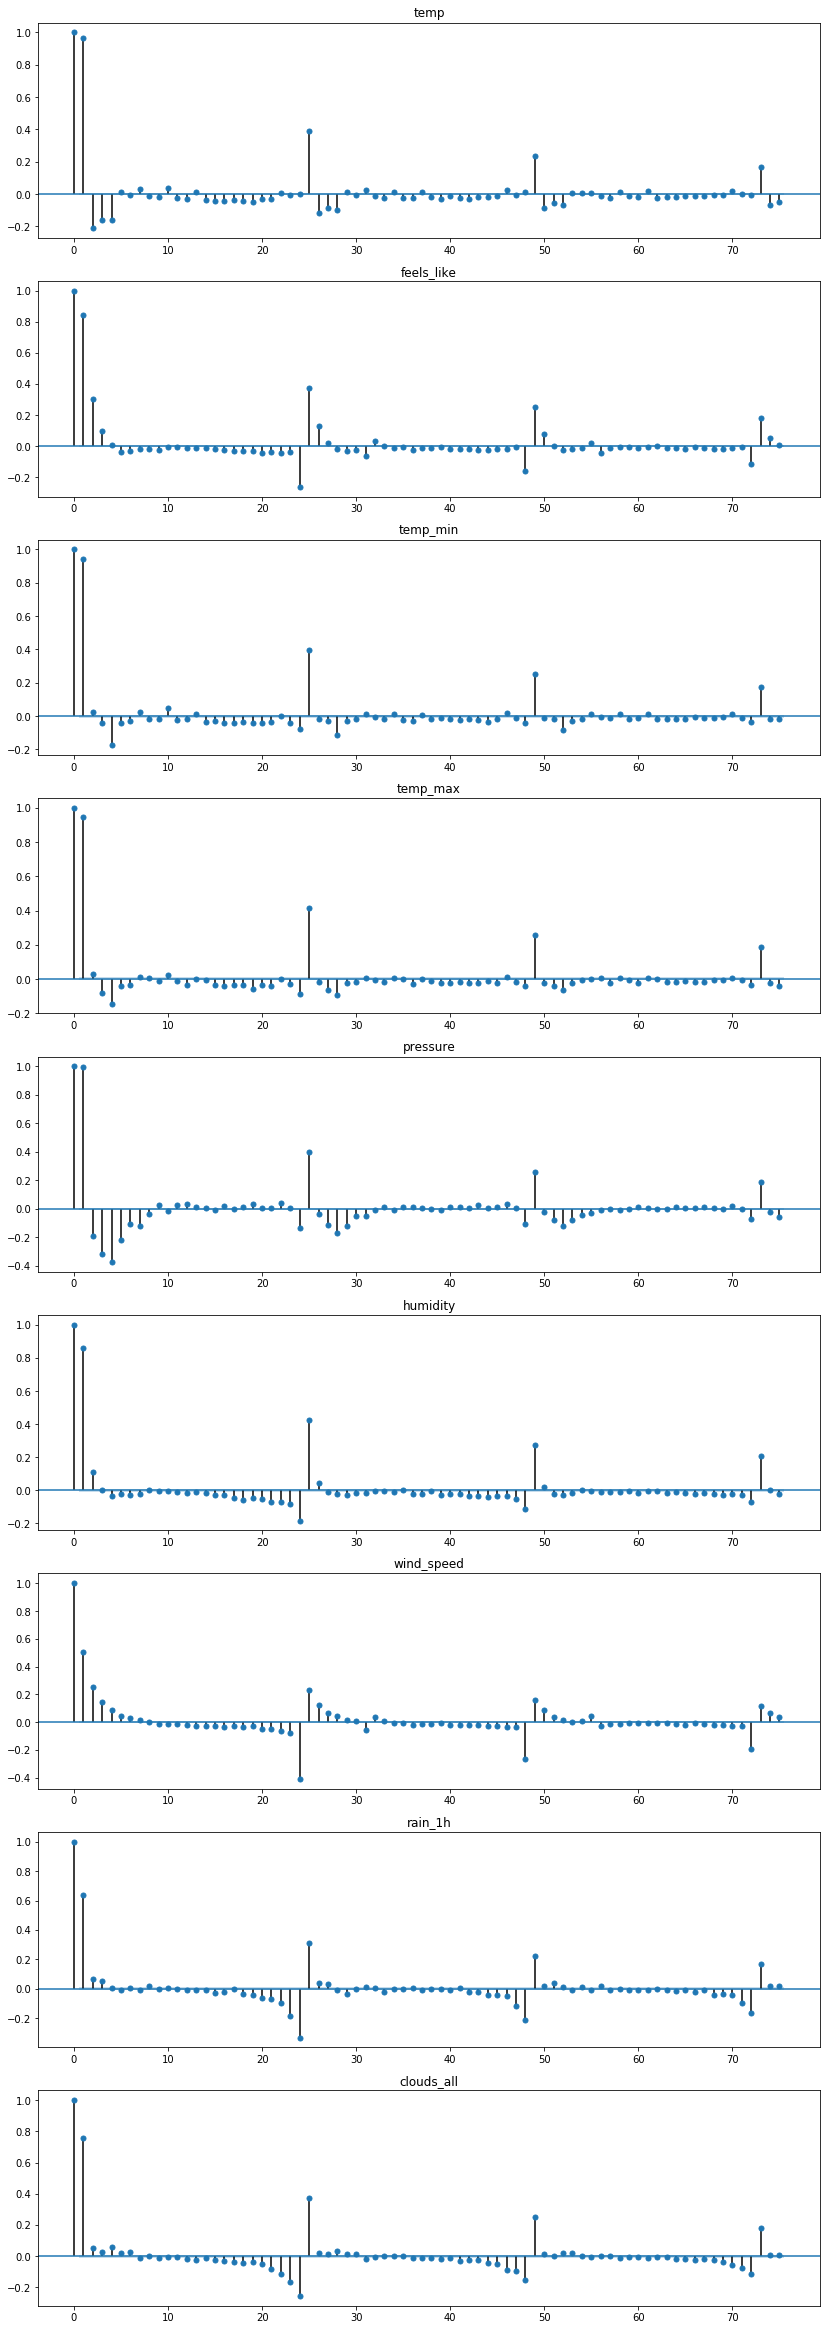

In [23]:
fig, ax_i = plt.subplots(nrows=len(col[:9]), figsize=(14, 42))
for i in range(len(col[:9])):
    plot_pacf(weather_df_fin[col[i]], ax = ax_i[i],
              lags=75, title = col[i])
plt.show()

## Feature engineering
1. Гармоники по длинным периодам сезонности
2. Индикаторы номера периода в коротких сезонах
3. Тренды (линейный, квадратичный)
4. Скользящие средние ряда за предыдущие периоды
5. t-1...-n


Гармоника по годовому периоду сезонности 

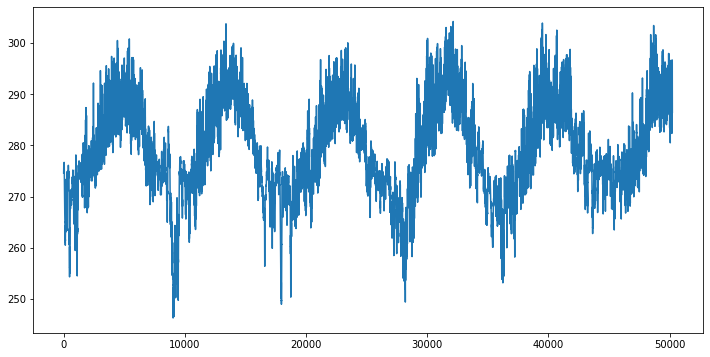

In [24]:
weather_df.temp.plot()

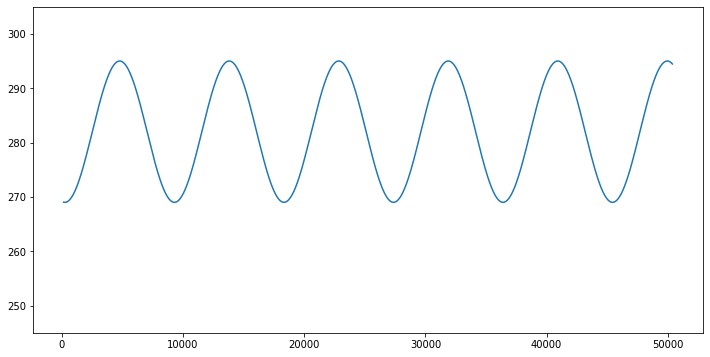

(50222, 50222)

In [25]:
time = np.arange(0+150,50222+150)
year_sin = 13*np.sin(time/(8916/6.2)-1.75)+282
plt.plot(time, year_sin)
plt.ylim(ymin=245, ymax=305)
plt.show()
len(time), len(year_sin)

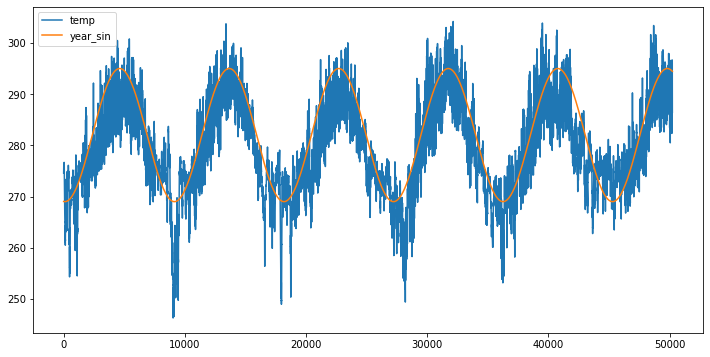

In [26]:
weather_df['year_sin'] = year_sin
weather_df[['temp','year_sin']].plot()

Скользящее среднее

In [27]:
FE_df = weather_df.copy()
for i in range(5,10):
    FE_df[f"temp_roll_{i}"] = weather_df.temp.rolling(i).mean()
    FE_df[f"feels_like_roll_{i}"] = weather_df.feels_like.rolling(i).mean()

FE_df = FE_df.replace(np.nan,0)

Сдвиг t-1...t-n

In [28]:
for i in range(1, 28):
    FE_df[f"temp_lag_{i}"] = weather_df.temp.shift(i)
    FE_df[f"feels_like_lag_{i}"] = weather_df.feels_like.shift(i)

FE_df = FE_df.replace(np.nan,0)

Добавляем данные приведенные к стационарному виду

In [29]:
df_diff = weather_df_diff.copy()
df_diff_col = []
for i in df_diff.columns:
    df_diff_col.append(i+'_stat')
df_diff.columns = df_diff_col
df_diff = df_diff.drop(['temp_stat', 'feels_like_stat'], axis=1)

Full_FE_df = FE_df[24:].copy()
Full_FE_df = pd.concat([Full_FE_df, df_diff], axis=1)

### without  - temp_min	 - temp_max

In [30]:
FE_WO_df = FE_df.drop(['temp_min', 'temp_max'], axis=1)

In [31]:
Full_WO_df = Full_FE_df.drop(['temp_min', 'temp_max'], axis=1)

## Feature selection
1. ALL - Full_FE_df
2. default without stat - FE_df
3. all without min max -  Full_WO_df
4. def without min max - FE_WO_df

In [32]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

In [33]:
def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [34]:
def split_and_scale(df):
    
    scaler = StandardScaler()
    y = df[['temp','feels_like']]
    X = df.drop(['temp','feels_like'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=0.3)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [35]:
def score_n_feat_sel(X_train, y_train):
    
    # get cv score and feature selection
    print(y_train.shape)
    tscv = TimeSeriesSplit(n_splits=5)
    l1_range=np.linspace(0.1,1,10).tolist()
    Enet_CV = ElasticNetCV(cv=tscv, l1_ratio=l1_range, n_jobs=-1)
    Enet_clf = MultiOutputRegressor(Enet_CV).fit(X_train, y_train)

    Enet_coefs_temp = pd.DataFrame({'Features': X_train.columns,
                                    'Importances': Enet_clf.estimators_[0].coef_})
    Enet_coefs_feel = pd.DataFrame({'Features': X_train.columns,
                                    'Importances': Enet_clf.estimators_[1].coef_})
    Enet_coefs_temp = Enet_coefs_temp.sort_values(by='Importances', ascending=False)
    Enet_coefs_temp = Enet_coefs_temp[Enet_coefs_temp.Importances>0]
    Enet_coefs_feel = Enet_coefs_feel.sort_values(by='Importances', ascending=False)
    Enet_coefs_feel = Enet_coefs_feel[Enet_coefs_feel.Importances>0]

    # CV score
    CV_score_1 = cross_val_score(ElasticNet(), X_train,
                                 y_train['temp'], cv=tscv).mean()
    CV_score_2 = cross_val_score(ElasticNet(), X_train,
                                 y_train['feels_like'], cv=tscv).mean()

    fig, ax_i = plt.subplots(2, figsize=(20, 20))
    Enet_coefs_temp.plot(kind='bar',x='Features', ax=ax_i[0], title = 'Temp')
    Enet_coefs_feel.plot(kind='bar',x='Features', ax=ax_i[1], title = 'Feels Like')
    plt.show()
    
    Enet_features_temp = list(Enet_coefs_temp.Features)
    Enet_features_feel = list(Enet_coefs_feel.Features)
    
    return Enet_features_temp, Enet_features_feel, round(CV_score_1, 3), round(CV_score_2, 3)

In [36]:
comparison = {'model': ['Full_data', 'Data_wo_stationar',
                        'Data_wo_minmax_temp',
                        'Data_wo_minmax_temp_and_stat'],
              'CV_score_1': [],
              'CV_score_2': [],
              'MSE_temp': [],
              'MAPE_temp': [],
              'MSE_feel': [],
              'MAPE_feel': []}

### Full data (Full_FE_df)

(35138, 2)


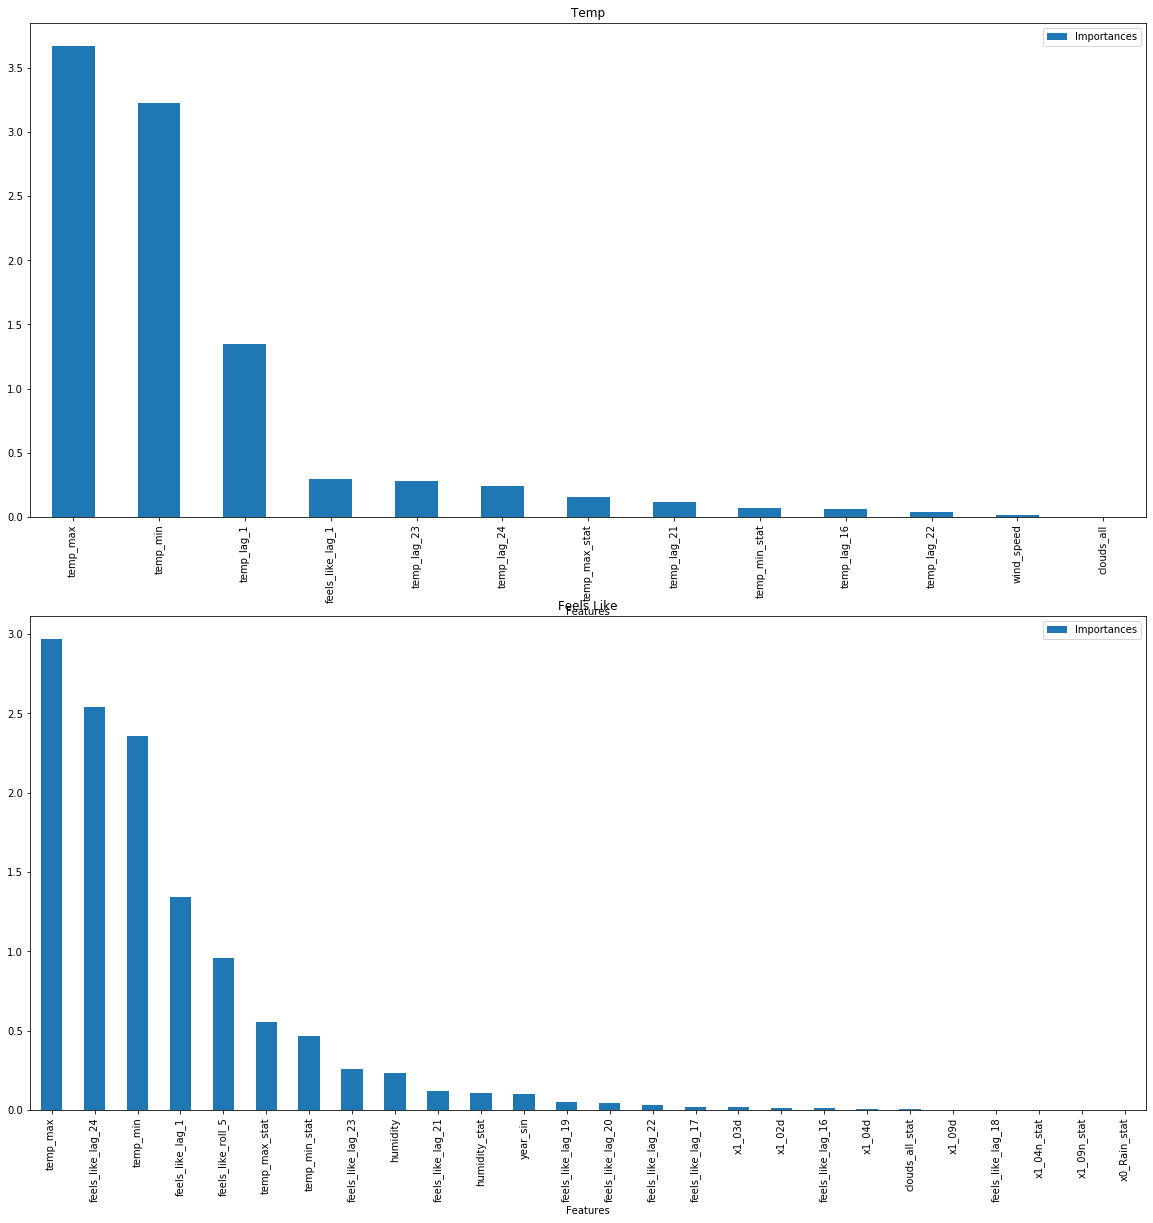

0.975 0.973


In [37]:
X_train, X_test, y_train, y_test = split_and_scale(Full_FE_df)
Enet_temp, Enet_feel, CV_score_1, CV_score_2 = score_n_feat_sel(X_train, y_train)
comparison['CV_score_1'].append(CV_score_1)
comparison['CV_score_2'].append(CV_score_2)
print(CV_score_1, CV_score_2)

### Data_wo_stationar (FE_df)

(35155, 2)


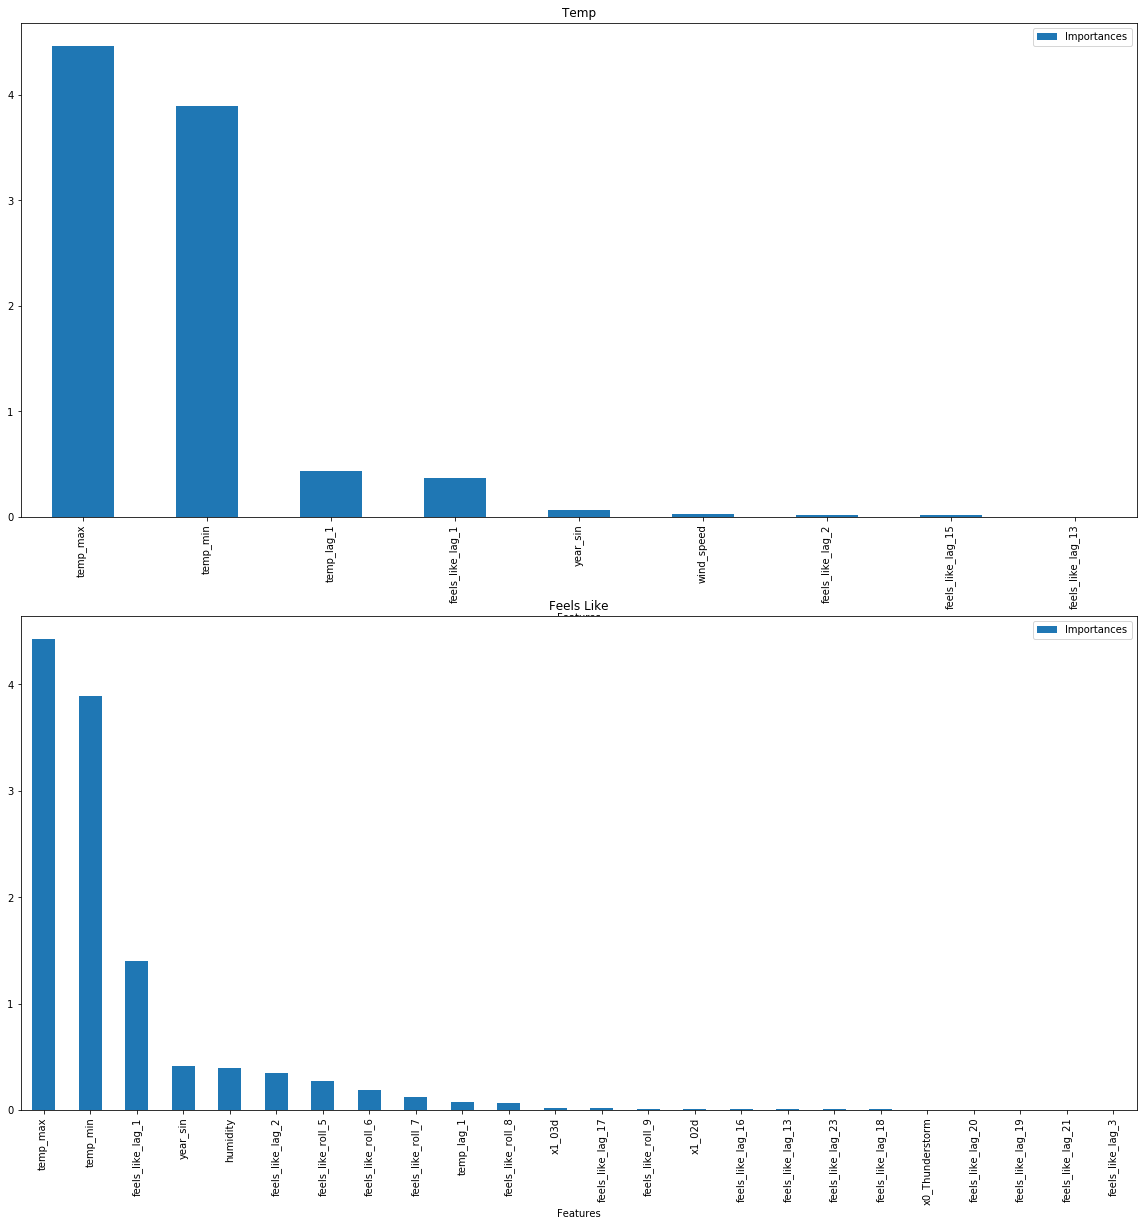

0.957 0.958


In [38]:
X_train, X_test, y_train, y_test = split_and_scale(FE_df)
Enet_temp_FE_df, Enet_feel_FE_df, CV_score_1, CV_score_2 = score_n_feat_sel(X_train, y_train)
comparison['CV_score_1'].append(CV_score_1)
comparison['CV_score_2'].append(CV_score_2)
print(CV_score_1, CV_score_2)

### Data_wo_minmax_temp (Full_WO_df)

(35138, 2)


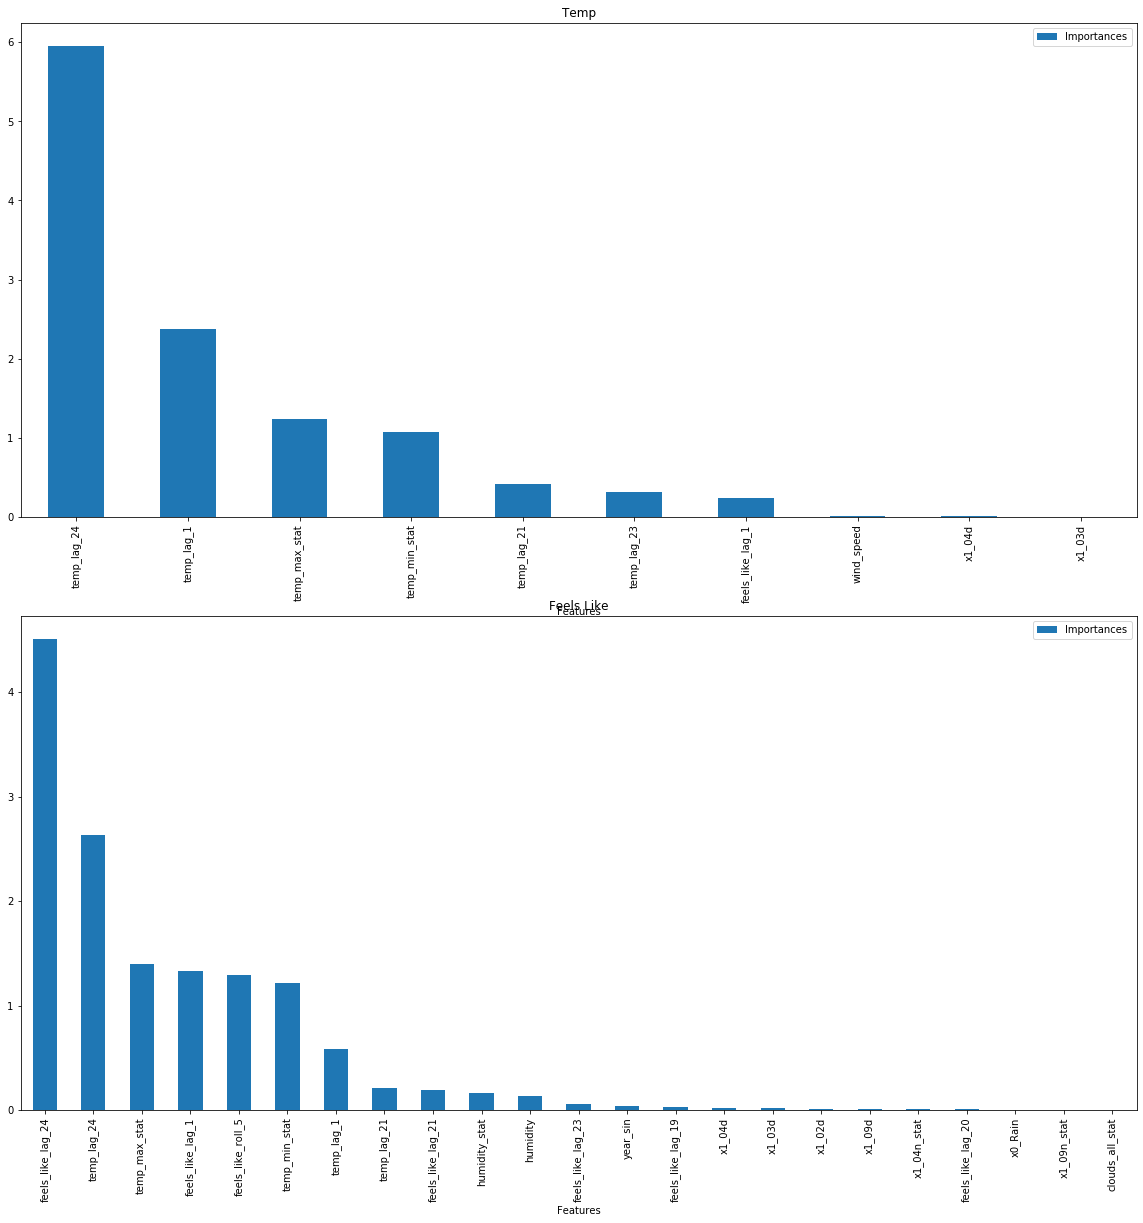

0.969 0.97


In [39]:
X_train, X_test, y_train, y_test = split_and_scale(Full_WO_df)
Enet_temp_Full_WO, Enet_feel_Full_WO, CV_score_1, CV_score_2 = score_n_feat_sel(X_train, y_train)
comparison['CV_score_1'].append(CV_score_1)
comparison['CV_score_2'].append(CV_score_2)
print(CV_score_1, CV_score_2)

### Data_wo_minmax_temp_and_stat (FE_WO_df)

(35155, 2)


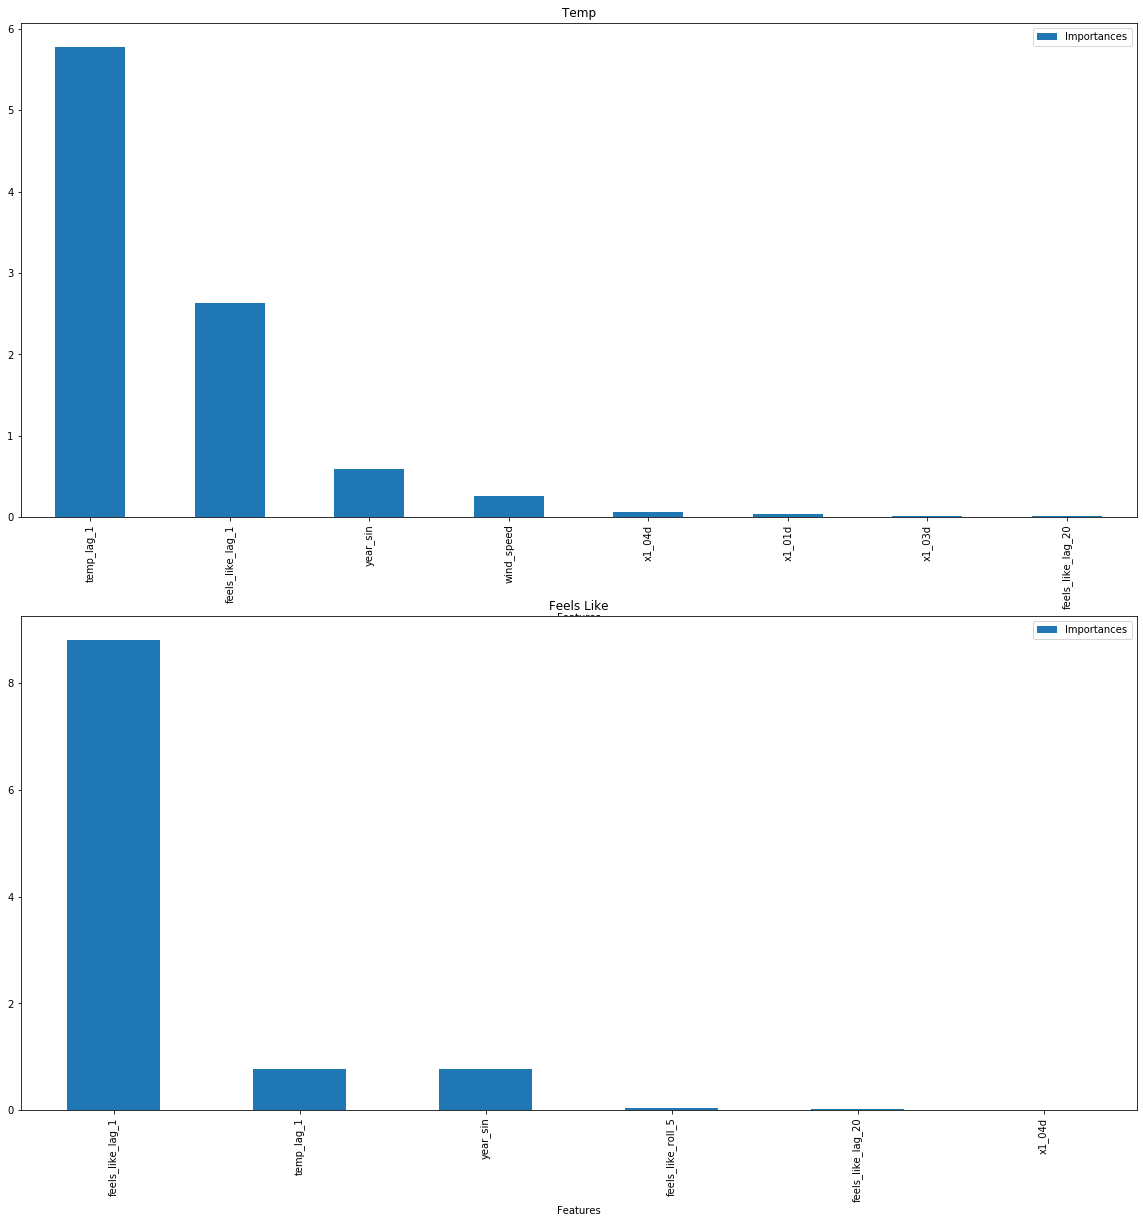

0.917 0.927


In [40]:
X_train, X_test, y_train, y_test = split_and_scale(FE_WO_df)
Enet_temp_FE_WO, Enet_feel_FE_WO, CV_score_1, CV_score_2 = score_n_feat_sel(X_train, y_train)
comparison['CV_score_1'].append(CV_score_1)
comparison['CV_score_2'].append(CV_score_2)
print(CV_score_1, CV_score_2)

## Предикт тестового набора данных на различных наборах фич по MSE,  MAE, MAPE

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [42]:
def plotModelResults(model, X_test, y_test):
    """
        Plots modelled vs fact values
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g--", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, 'b:', label="actual", linewidth=2.0)   
    
    mae = round(mean_absolute_error(prediction, y_test),3)
    mse = round(mean_squared_error(prediction, y_test),3)
    mape = mae*100/y_test.mean()
    plt.title(f"MAE = {mae}, MSE = {mse} and MAPE = {mape}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
    return mse, mape

### XGBoost

## 1

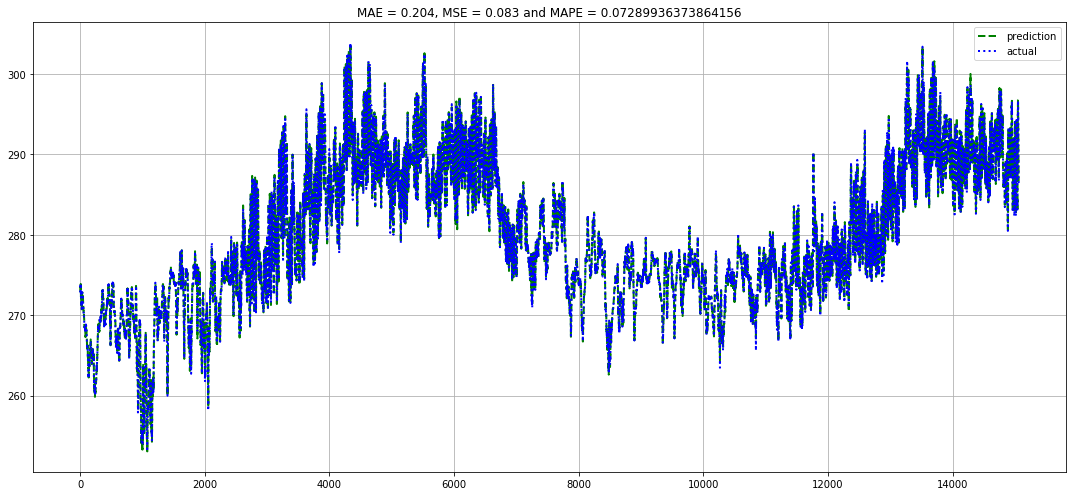

In [43]:
import xgboost as xgb

y = Full_FE_df['temp']
X = Full_FE_df[Enet_temp]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_temp'].append(mse)
comparison['MAPE_temp'].append(mape)

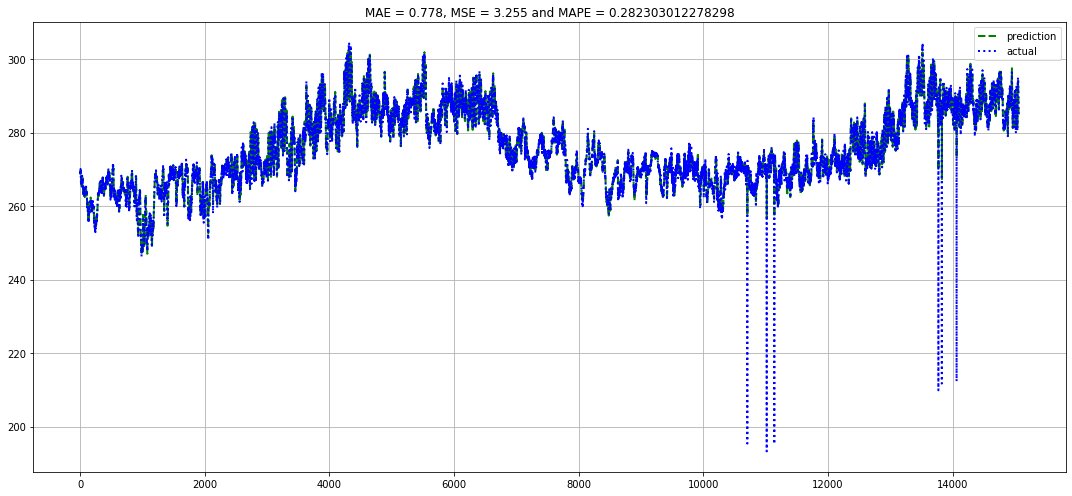

In [44]:
y = Full_FE_df['feels_like']
X = Full_FE_df[Enet_feel]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_feel'].append(mse)
comparison['MAPE_feel'].append(mape)

## 2

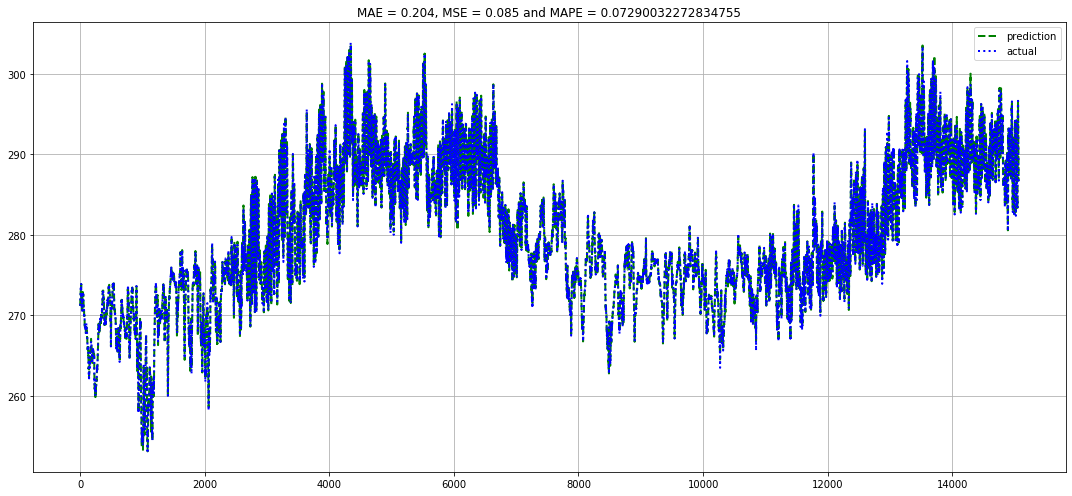

In [45]:
y = FE_df['temp']
X = FE_df[Enet_temp_FE_df]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_temp'].append(mse)
comparison['MAPE_temp'].append(mape)

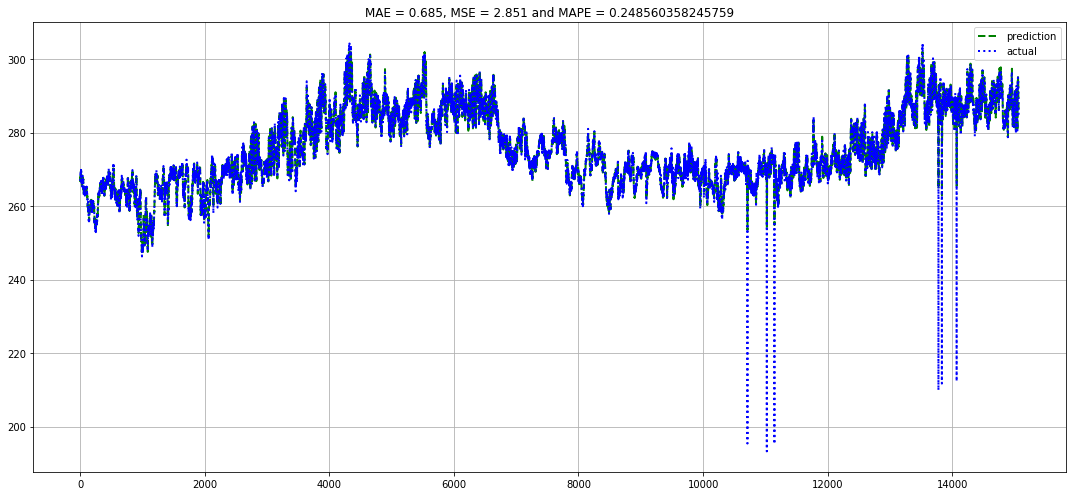

In [46]:
y = FE_df['feels_like']
X = FE_df[Enet_feel_FE_df]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_feel'].append(mse)
comparison['MAPE_feel'].append(mape)

## 3

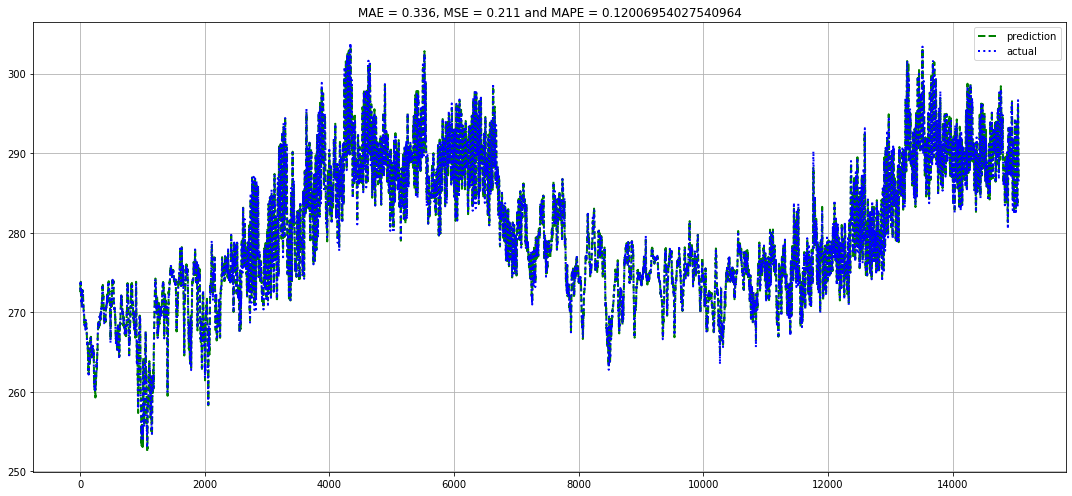

In [47]:
y = Full_WO_df['temp']
X = Full_WO_df[Enet_temp_Full_WO]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_temp'].append(mse)
comparison['MAPE_temp'].append(mape)

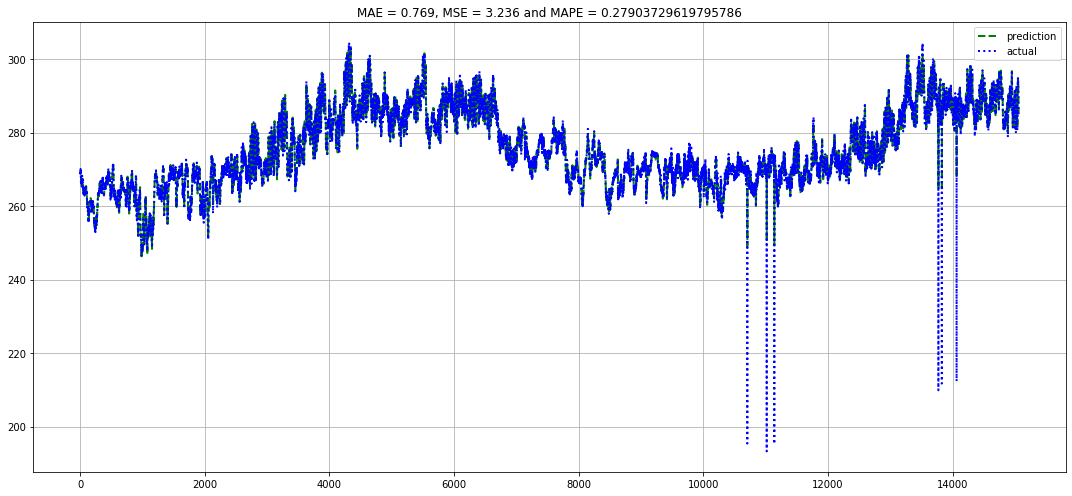

In [48]:
y = Full_WO_df['feels_like']
X = Full_WO_df[Enet_feel_Full_WO]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_feel'].append(mse)
comparison['MAPE_feel'].append(mape)

## 4

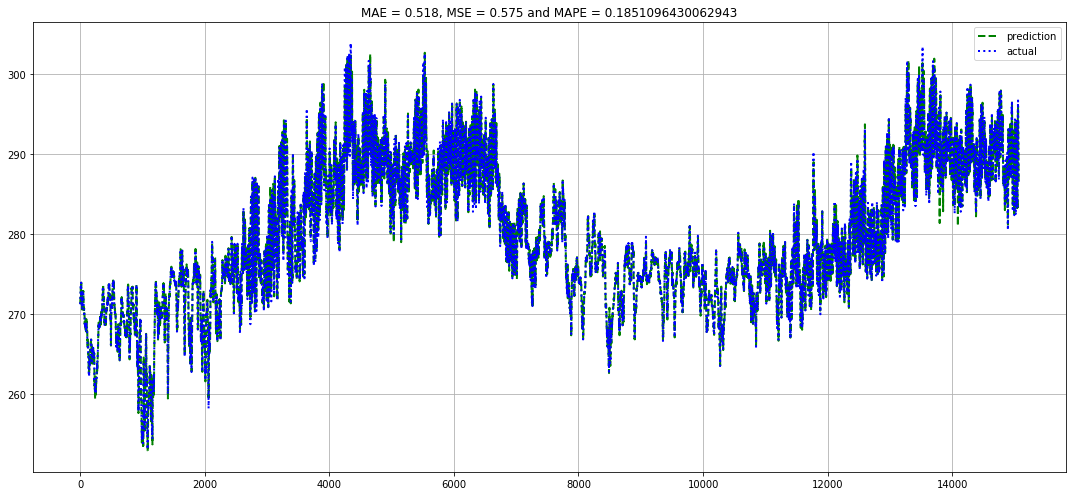

In [49]:
y = FE_WO_df['temp']
X = FE_WO_df[Enet_temp_FE_WO]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_temp'].append(mse)
comparison['MAPE_temp'].append(mape)

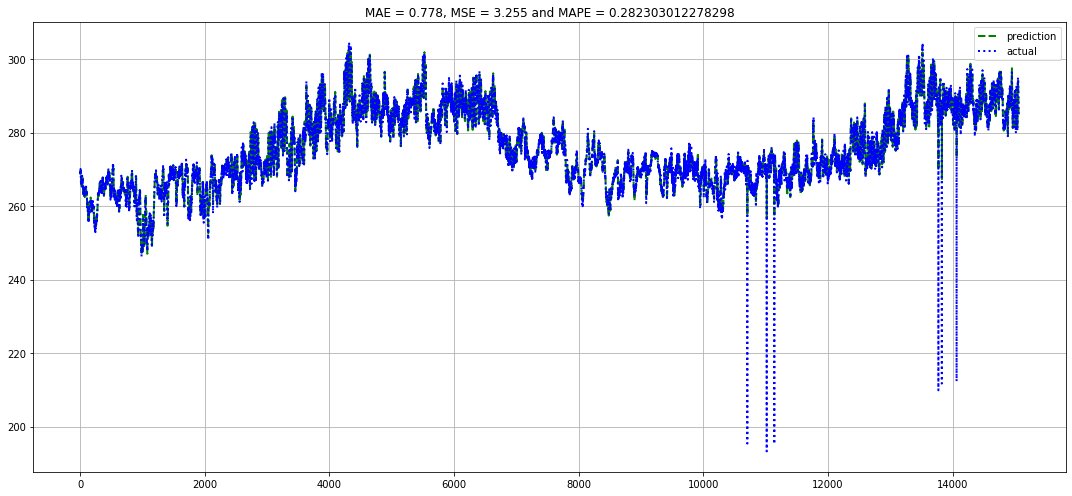

In [50]:
y = Full_FE_df['feels_like']
X = Full_FE_df[Enet_feel]
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X_train, y_train, verbose=2)
mse, mape = plotModelResults(xg, X_test, y_test)
comparison['MSE_feel'].append(mse)
comparison['MAPE_feel'].append(mape)

In [51]:
comparison2 = pd.DataFrame.from_dict(comparison, orient='columns')
comparison2

,model,CV_score_1,CV_score_2,MSE_temp,MAPE_temp,MSE_feel,MAPE_feel
0,Full_data,0.975,0.973,0.083,0.072899,3.255,0.282303
1,Data_wo_stationar,0.957,0.958,0.085,0.072900,2.851,0.248560
2,Data_wo_minmax_temp,0.969,0.970,0.211,0.120070,3.236,0.279037
3,Data_wo_minmax_temp_and_stat,0.917,0.927,0.575,0.185110,3.255,0.282303
